In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import gc
import random

from IPython import display as ipd
from tqdm import tqdm
import lightgbm as lgb

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import RandomOverSampler


/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-dec-2021/train.csv
/kaggle/input/tabular-playground-series-dec-2021/test.csv


0.8.1


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col != 'time':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def get_stats(df):
    stats = pd.DataFrame(index=df.columns, columns=['na_count', 'n_unique', 'type', 'memory_usage'])
    for col in df.columns:
        stats.loc[col] = [df[col].isna().sum(), df[col].nunique(dropna=False), df[col].dtypes, df[col].memory_usage(deep=True, index=False) / 1024**2]
    stats.loc['Overall'] = [stats['na_count'].sum(), stats['n_unique'].sum(), None, df.memory_usage(deep=True).sum() / 1024**2]
    return stats

def seeding(SEED, use_tf=False):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    if use_tf:
        tf.random.set_seed(SEED)
    print('seeding done!!!')

In [3]:
RANDOM_SEED = 42
DEBUG = True
PROFILE = False

seeding(RANDOM_SEED)

train = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/test.csv')
submission = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv')

target = train.Cover_Type
train.drop(['Id','Cover_Type'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# reduce memory footprint
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
gc.collect()

seeding done!!!
Mem. usage decreased to 240.33 Mb (85.4% reduction)
Mem. usage decreased to 60.08 Mb (85.4% reduction)


0

## Dealing with imbalanced targets

<AxesSubplot:>

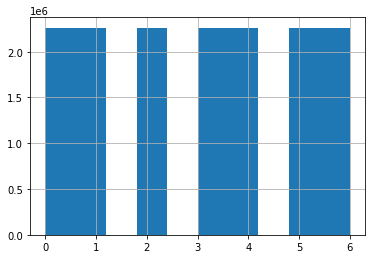

In [4]:
# map targets to match LGBM class reqs
def remap_target_classes(y):
    for i in range(1,8):
        y[y==i] = i-1
    return y

sampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_SEED)
X_sample, y_sample = sampler.fit_resample(train, target)

y_sample = remap_target_classes(y_sample)
# doublecheck class distribution
y_sample.hist()

In [5]:
## to speed thing up - resample and reduce the size of train and target datasets

if DEBUG:
    temp = pd.concat( [X_sample, y_sample], axis=1 )
    temp = temp.sample(frac=1.0)
    temp = temp[:600000]
    y = temp.Cover_Type
    X = temp.drop(['Cover_Type'], axis=1)
else:
    y = y_sample
    X = X_sample

## Display classes

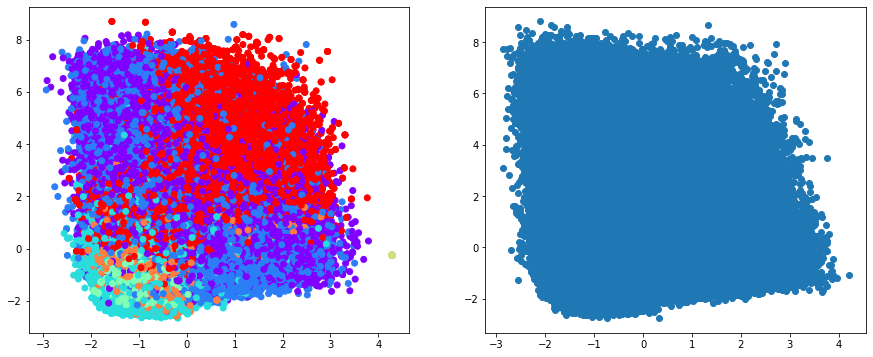

In [6]:
scaler = RobustScaler()
train_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(train_scaled)
X_pca_test = pca.transform(test_scaled)

f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
ax1.scatter(X_pca_train[:,0],X_pca_train[:,1],c=y,cmap='rainbow')
ax2.scatter(X_pca_test[:,0],X_pca_test[:,1],cmap='rainbow')
plt.show()

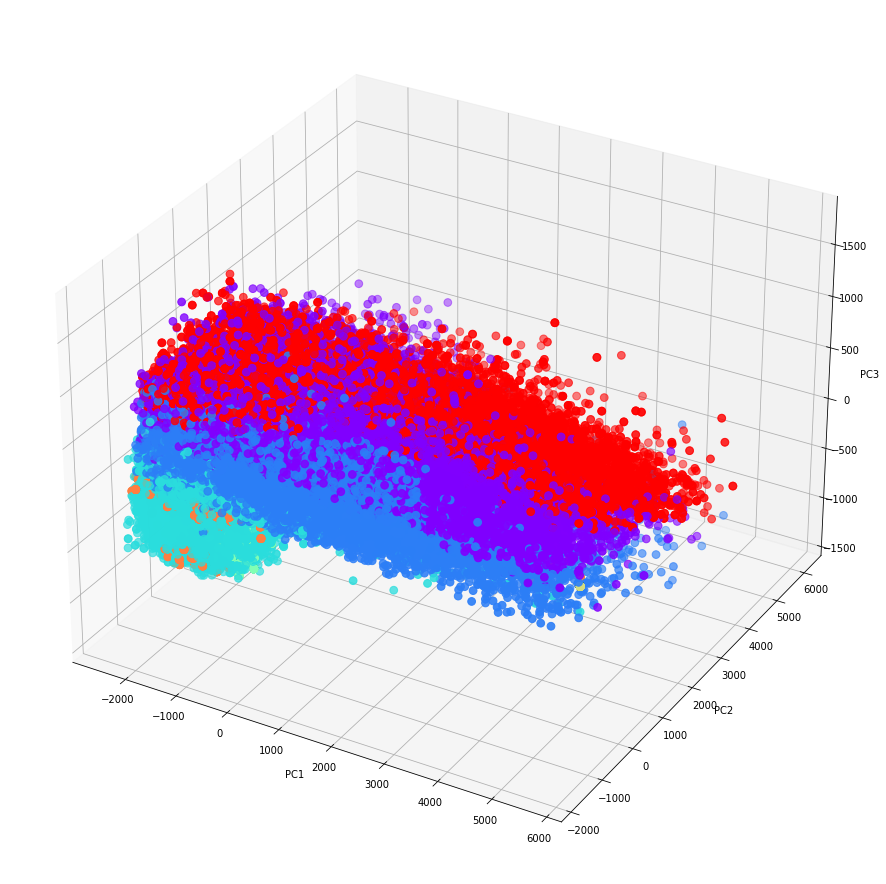

In [7]:
# let's try 3D
pca = PCA(n_components=3)
pca.fit(X)
 
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(X), columns=['PCA%i' % i for i in range(3)], index=X.index)
 
# Plot initialisation
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=y, s=60, cmap='rainbow')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

## How to Use t-SNE Effectively

https://distill.pub/2016/misread-tsne/

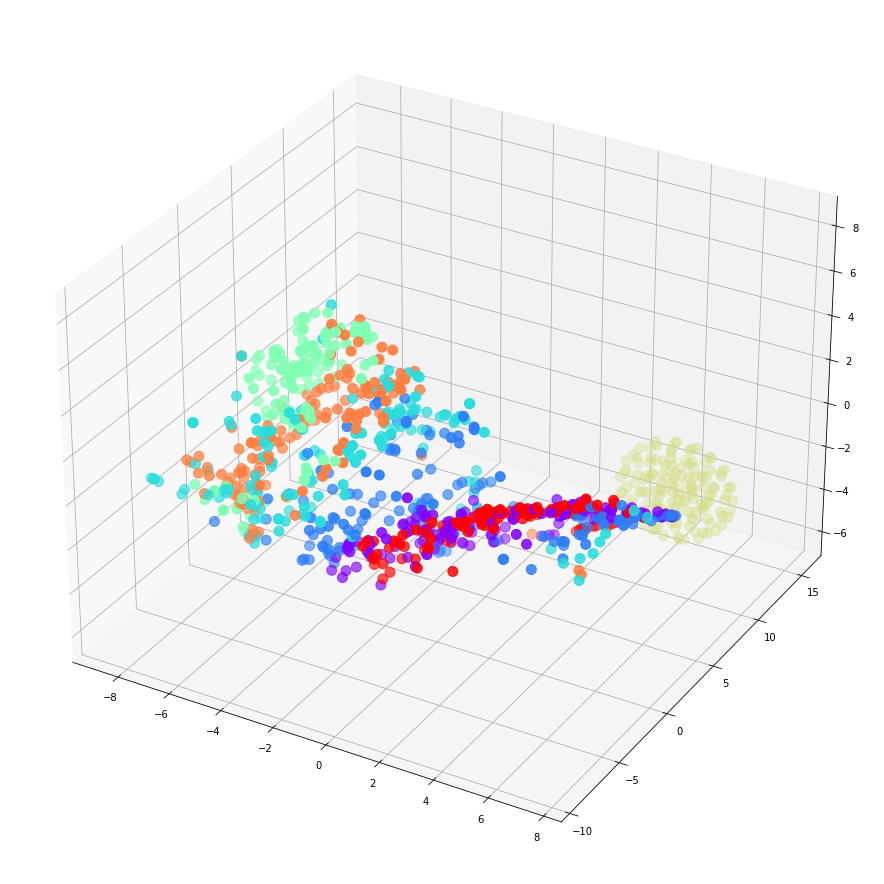

CPU times: user 44.7 s, sys: 146 ms, total: 44.8 s
Wall time: 11.8 s


In [8]:
%%time

## takes too much time, need to reduce size even more
xx = X[:1000]
yy = y[:1000]

tsne = TSNE(n_components=3, learning_rate=25, early_exaggeration=20, random_state=RANDOM_SEED, perplexity=50)
tsne_result=pd.DataFrame(tsne.fit_transform(xx), columns=['TSNE%i' % i for i in range(3)], index=xx.index)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result['TSNE0'], tsne_result['TSNE1'], tsne_result['TSNE2'], c=yy, s = 100, cmap='rainbow')
plt.show()

## Model and train

In [9]:
%%time

LEARNING_RATE = 0.08
MAX_DEPTH = -1
NUM_LEAVES = 400
NUM_BOOST_ROUND = 500
EARLY_STOPPING_ROUNDS = 20
VERBOSE_EVAL = 100
    
run_params = {
    'verbose': -1, 
    'boosting_type': 'gbdt', 
    'objective': 'multiclass', 
    'metric': ['multi_logloss'],
    'learning_rate': LEARNING_RATE, 
    'num_leaves': NUM_LEAVES, 
    'max_depth': MAX_DEPTH,
    'lambda_l1': 0,
    'lambda_l2': 45,      
    'num_class' : 7
}

X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.25, random_state=RANDOM_SEED, shuffle=True)
eval_results = {}  # to record eval results for plotting
model = lgb.train(
    run_params, valid_names=["train", "valid"], 
    train_set=lgb.Dataset(X_train, y_train ), 
    num_boost_round = NUM_BOOST_ROUND,
    valid_sets = [lgb.Dataset(X_valid, y_valid)],
    callbacks=[lgb.log_evaluation(VERBOSE_EVAL), 
               lgb.early_stopping(EARLY_STOPPING_ROUNDS, False, True),
               lgb.record_evaluation(eval_result=eval_results)],
)


Training until validation scores don't improve for 20 rounds
[100]	train's multi_logloss: 0.0767923
[200]	train's multi_logloss: 0.0651102
[300]	train's multi_logloss: 0.0620107
[400]	train's multi_logloss: 0.0613097
Early stopping, best iteration is:
[430]	train's multi_logloss: 0.061253
CPU times: user 12min 20s, sys: 8.26 s, total: 12min 28s
Wall time: 3min 12s


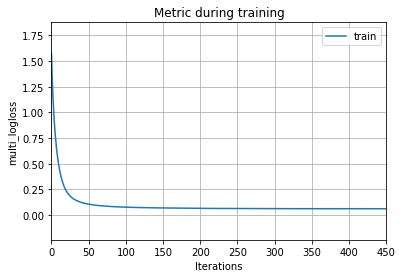

In [10]:
ax = lgb.plot_metric(eval_results, metric='multi_logloss')
plt.show()

In [11]:
yhat = np.argmax(model.predict(X, workers=8), axis=1)
score = f1_score(yhat, y, average="macro")
print(f"Model F1 Macro Score: {score}" )

Model F1 Macro Score: 0.9948285120858851


## Predict

In [12]:
y_pred = np.argmax(model.predict(test), axis=1)

# map targets back 
y_pred[y_pred== 6] = 7
y_pred[y_pred== 5] = 6
y_pred[y_pred== 4] = 5
y_pred[y_pred== 3] = 4
y_pred[y_pred== 2] = 3
y_pred[y_pred== 1] = 2
y_pred[y_pred== 0] = 1

submission['Cover_Type'] = y_pred
submission.to_csv('submission.csv', index=False, float_format='%.6f')
submission.head(20)

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
5,4000005,3
6,4000006,2
7,4000007,1
8,4000008,2
9,4000009,3
